In [1]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import numpy as np
import tensorflow as tf
import seaborn as sn
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from helpers import convert_to_onehot

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
class_names = ['neutralne', 'oczekiwanie', 'podziw', 'radosc', 'smutek', 'strach', 'wstret', 'zaskoczenie', 'zlosc']

## Get train and test datasets and process them to be TF Dataset objects

In [7]:
# with open('../data/embeddings.pickle', 'rb') as handle:
#     train = pickle.load(handle)
    
# with open('../data/test_embedding.pickle', 'rb') as handle:
#     test = pickle.load(handle)
    
with open('../data/train.pickle', 'rb') as handle:
    org_train_X, org_train_y = pickle.load(handle)

with open('../data/test.pickle', 'rb') as handle:
    org_test_X, org_test_y = pickle.load(handle)
    
# with open('../data/slowosiec_train.pickle', 'rb') as handle:
#     org_train_X, org_train_y = pickle.load(handle)

with open('../data/slowosiec_test.pickle', 'rb') as handle:
    org_test_X, org_test_y = pickle.load(handle)
    
def is_neutral(idx):
#     print(idx, type(org_test_y[idx]), type(convert_to_onehot('neutralne')))
    return np.all([org_test_y[idx] == np.array(convert_to_onehot('neutralne'))])
    
# train_X = np.array([data[0][0] for data in train])
# train_y = np.array([convert_to_onehot(data[1]) for data in train])
# test_X = np.array([data for idx, data in enumerate(org_test_X) if not is_neutral(idx)])
# test_y = np.array([data for idx, data in enumerate(org_test_y) if not is_neutral(idx)])
# test_X = np.array([data[0].numpy()[0] for data in test])
# test_y = np.array([convert_to_onehot(data[1]) for data in test])
train_X = np.array(org_train_X)
train_y = np.array(org_train_y)
test_X = np.array(org_test_X)
test_y = np.array(org_test_y)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3368, 768)
(3368, 9)
(16066, 768)
(16066, 9)


In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_dataset = test_dataset.batch(BATCH_SIZE)

## Define 2 layer model with dropout

Train with RMSprop as an optimizer because it works better with momentum.

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(768,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(9, activation="softmax", name="predictions")
])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001, decay_steps=1000, decay_rate=0.96, staircase=True
)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, rho=0.9, momentum=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])
model.fit(train_dataset, epochs=120)

Epoch 1/120
53/53 [==============================] - 0s 4ms/step - loss: 1.3854 - categorical_accuracy: 0.5947
Epoch 2/120
53/53 [==============================] - 0s 4ms/step - loss: 1.1806 - categorical_accuracy: 0.6470
Epoch 3/120
53/53 [==============================] - 0s 4ms/step - loss: 1.1205 - categorical_accuracy: 0.6633
Epoch 4/120
53/53 [==============================] - 0s 3ms/step - loss: 1.0901 - categorical_accuracy: 0.6692
Epoch 5/120
53/53 [==============================] - 0s 4ms/step - loss: 1.0440 - categorical_accuracy: 0.6829
Epoch 6/120
53/53 [==============================] - 0s 4ms/step - loss: 1.0243 - categorical_accuracy: 0.6882
Epoch 7/120
53/53 [==============================] - 0s 4ms/step - loss: 1.0082 - categorical_accuracy: 0.6966
Epoch 8/120
53/53 [==============================] - 0s 4ms/step - loss: 0.9907 - categorical_accuracy: 0.7034
Epoch 9/120
53/53 [==============================] - 0s 4ms/step - loss: 0.9871 - categorical_accuracy: 0.7058
E

53/53 [==============================] - 0s 4ms/step - loss: 0.4818 - categorical_accuracy: 0.8328
Epoch 75/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4756 - categorical_accuracy: 0.8293
Epoch 76/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4639 - categorical_accuracy: 0.8370
Epoch 77/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4738 - categorical_accuracy: 0.8420
Epoch 78/120
53/53 [==============================] - 0s 4ms/step - loss: 0.4605 - categorical_accuracy: 0.8343
Epoch 79/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4583 - categorical_accuracy: 0.8432
Epoch 80/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4516 - categorical_accuracy: 0.8397
Epoch 81/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4466 - categorical_accuracy: 0.8412
Epoch 82/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4412 - categorical_accuracy: 0.8501
Epoch

## Get model schema

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 9)                 1161      
Total params: 230,921
Trainable params: 230,921
Non-trainable params: 0
_________________________________________________________________


## Make predictions on test dataset and calculate classification metrics

In [12]:
raw_data = model.predict(test_dataset)
predictions = np.argmax(raw_data, axis=-1)
true_y = np.argmax(test_y, axis=-1)
true_y[0]

3

In [24]:
print(classification_report(true_y, predictions, target_names=class_names))

              precision    recall  f1-score   support

   neutralne       0.00      0.00      0.00         0
 oczekiwanie       0.02      0.01      0.01       328
      podziw       0.13      0.10      0.12      1280
      radosc       0.37      0.16      0.22      2455
      smutek       0.26      0.06      0.10      3601
      strach       0.09      0.04      0.05       938
      wstret       0.33      0.03      0.05      2844
 zaskoczenie       0.04      0.01      0.02       246
       zlosc       0.41      0.17      0.24      4374

    accuracy                           0.10     16066
   macro avg       0.18      0.06      0.09     16066
weighted avg       0.30      0.10      0.14     16066



## Check missed predictions

In [15]:
miss_class = (predictions != true_y).nonzero()[0]

In [16]:
miss_class[:15]

array([ 0,  1,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [17]:
## get original texts instead of embedded vectors
with open('../data/slowosiec_test_org.pickle', 'rb') as handle:
    test_X_org = pickle.load(handle)

In [30]:
for idx in miss_class[:15]:
    print(f"Predicted: {class_names[predictions[idx]]}, Acc label: {class_names[true_y[idx]]}")
    print(raw_data[idx])
    print(test_X_org[idx])
    print()

Predicted: neutralne, Acc label: radosc
[9.9994254e-01 7.4560127e-09 8.5019209e-09 5.7496385e-05 7.2090263e-15
 9.9097923e-19 7.2187552e-26 1.9915094e-21 5.0546215e-13]
Mam dostateczną ilość wody dla nas dwóch.

Predicted: neutralne, Acc label: radosc
[9.9795425e-01 5.5419747e-05 4.7846188e-06 1.9701172e-03 1.5323165e-05
 3.7801519e-11 1.9573352e-11 2.7773137e-09 1.2193912e-07]
Zgotujemy mu takie przyjęcie powitalne, jakiego nigdy nie miał!

Predicted: smutek, Acc label: zlosc
[2.4495538e-02 1.0514115e-05 4.6273335e-08 7.7900535e-05 8.7692165e-01
 8.8876970e-02 4.5903747e-09 1.7525557e-03 7.8649037e-03]
Zjadliwość tej starej klempy działa mi na nerwy - w końcu jej coś odpowiem tak, że się nogami nakryje. 

Predicted: neutralne, Acc label: radosc
[9.9994218e-01 8.4419889e-06 2.0340089e-10 3.0266139e-05 2.0215186e-06
 1.8320486e-13 7.9049007e-12 7.1815557e-13 1.7003205e-05]
Rano niebo było czyściutkie, co zwiastuje świetną pogodę.

Predicted: strach, Acc label: zlosc
[1.8945277e-01 3.753

<AxesSubplot:>

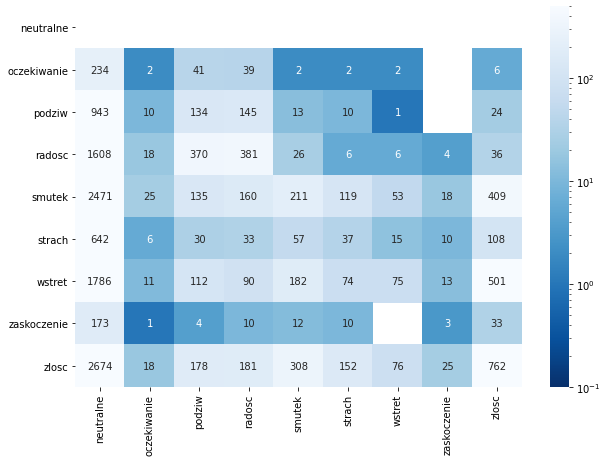

In [22]:
cm = confusion_matrix(true_y, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))

sn.heatmap(df_cm, cmap="Blues_r", annot=True, norm=LogNorm(vmin=0.1, vmax=500), fmt="d")

In [23]:
cm

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 234,    2,   41,   39,    2,    2,    2,    0,    6],
       [ 943,   10,  134,  145,   13,   10,    1,    0,   24],
       [1608,   18,  370,  381,   26,    6,    6,    4,   36],
       [2471,   25,  135,  160,  211,  119,   53,   18,  409],
       [ 642,    6,   30,   33,   57,   37,   15,   10,  108],
       [1786,   11,  112,   90,  182,   74,   75,   13,  501],
       [ 173,    1,    4,   10,   12,   10,    0,    3,   33],
       [2674,   18,  178,  181,  308,  152,   76,   25,  762]])